In [ ]:
import numpy as np
import ants

In [9]:
import ants
import numpy as np

# Generate synthetic fixed and moving images
fixed_image = ants.from_numpy(np.eye(64))  # Identity matrix as the fixed image
moving_image = ants.from_numpy(np.roll(np.eye(64), 5, axis=1))  # Shifted identity as the moving image

# Save the generated images for reference
fixed_image.to_file("fixed_image.nii.gz")
moving_image.to_file("moving_image.nii.gz")

# Perform registration with initial_transform=None
reg_none = ants.registration(
    fixed=fixed_image,
    moving=moving_image,
    type_of_transform="SyNOnly",
    initial_transform=None,  # Default: computes center-of-mass alignment
    outprefix="test_none_"
)
print("Transforms (None):", reg_none["invtransforms"])

# Perform registration with initial_transform='Identity'
reg_identity = ants.registration(
    fixed=fixed_image,
    moving=moving_image,
    type_of_transform="SyNOnly",
    initial_transform="Identity",  # No initial transform
    outprefix="test_identity_"
)
print("Transforms (Identity):", reg_identity["invtransforms"])

# # Perform registration with a precomputed transform
# # Here, we'll save a simple affine transform matrix to a file
# precomputed_transform_file = "precomputed_transform.mat"
# np.savetxt(precomputed_transform_file, np.eye(4))  # Identity matrix as a transform

# reg_precomputed = ants.registration(
#     fixed=fixed_image,
#     moving=moving_image,
#     type_of_transform="SyNOnly",
#     initial_transform=precomputed_transform_file,
#     outprefix="test_precomputed_"
# )
# print("Transforms (Precomputed):", reg_precomputed["invtransforms"])


Transforms (None): ['test_none_0GenericAffine.mat', 'test_none_1InverseWarp.nii.gz']
Transforms (Identity): ['test_identity_0GenericAffine.mat', 'test_identity_1InverseWarp.nii.gz']


In [ ]:
mat_file_path=reg_identity['invtransforms'][0]
# Load the transform using ANTsPy
transform = ants.read_transform(mat_file_path)

# Extract the affine matrix
affine_matrix = transform.parameters
print(affine_matrix)
print(transform.fixed_parameters)

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (64, 64)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (64, 64)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['test_identity_1Warp.nii.gz',
  'test_identity_0GenericAffine.mat'],
 'invtransforms': ['test_identity_0GenericAffine.mat',
  'test_identity_1InverseWarp.nii.gz']}

In [ ]:
def compute_intermediate_non_linear_slice(pre_img, post_img, current_img=None, additional_coreg_mean = True, 
                                          idx=None):

    import numpy
    import tempfile
    import ants

    # Load images using ANTs
    pre_ants = ants.image_read(pre_img)
    post_ants = ants.image_read(post_img)

    # Step 1: Perform rigid registration from pre to post slice and post to pre slice
    pre_to_post_rigid = ants.registration(fixed=post_ants, moving=pre_ants, type_of_transform='Rigid')
    post_to_pre_rigid = ants.registration(fixed=pre_ants, moving=post_ants, type_of_transform='Rigid')

    # Step 2: Apply the rigid transformation to each image for initial alignment
    pre_aligned = pre_to_post_rigid['warpedmovout']
    post_aligned = post_to_pre_rigid['warpedmovout']
    
    # pre_aligned = ants.apply_transforms(fixed=post_ants, moving=pre_ants, transformlist=pre_to_post_rigid['fwdtransforms'])
    # post_aligned = ants.apply_transforms(fixed=pre_ants, moving=post_ants, transformlist=post_to_pre_rigid['fwdtransforms'])

    # # Step 3: Perform non-linear registration on the rigidly aligned images
    # we use full syn b/c we actually want the intermediate image to be the size in between the two (so include affine here)
    pre_to_post_nonlin = ants.registration(fixed=post_aligned, moving=pre_aligned, type_of_transform='SyNOnly',
                                           initial_transform='Identity') #must select identity as initial transform since we already did rigid
    post_to_pre_nonlin = ants.registration(fixed=pre_aligned, moving=post_aligned, type_of_transform='SyNOnly',
                                           initial_transform='Identity')

    # Step 4: Load the non-linear deformation fields as images
    # https://antspy.readthedocs.io/en/latest/registration.html #for reference
    pre_to_post_field = ants.image_read(pre_to_post_nonlin['fwdtransforms'][0]) # 2nd on the stack is the Affine
    post_to_pre_field = ants.image_read(post_to_pre_nonlin['invtransforms'][1]) # grab the inverse deformation field, which is the 2nd on the stack for inverted


    # Step 5: Convert the deformation fields to NumPy arrays and average them
    avg_field_data = (pre_to_post_field.numpy() + post_to_pre_field.numpy()) / 2
    avg_field = ants.from_numpy(avg_field_data, spacing=pre_to_post_field.spacing+(1.0,)) #need a 3rd dimension for spacing
    
    #we need to have the transform as a file, so we create a temp version here
    with tempfile.NamedTemporaryFile(suffix='.nii.gz') as temp_file:
        avg_field_path = temp_file.name
        ants.image_write(avg_field, avg_field_path)

        ## apply within the with statement to use the file prior to deletion (default is non- persistence)
        # Step 6: Apply the averaged non-linear deformation field to the rigidly aligned pre-image
        intermediate_img = ants.apply_transforms(fixed=post_ants, moving=pre_aligned, transformlist=[avg_field_path])

    intermediate_img_np = intermediate_img.numpy()

    # if you want to, we now coregister the images to the new target and then take their mean
    if additional_coreg_mean: 
        # Step 1: Perform rigid registration from pre to post slice and post to pre slice
        pre_to_post_rigid = ants.registration(fixed=intermediate_img, moving=pre_ants, type_of_transform='Rigid')
        post_to_pre_rigid = ants.registration(fixed=intermediate_img, moving=post_ants, type_of_transform='Rigid')

        # Step 2: Apply the rigid transformation to each image for initial alignment
        pre_aligned = ants.apply_transforms(fixed=intermediate_img, moving=pre_ants, transformlist=pre_to_post_rigid['fwdtransforms'])
        post_aligned = ants.apply_transforms(fixed=intermediate_img, moving=post_ants, transformlist=post_to_pre_rigid['fwdtransforms'])


        # # Step 3: Perform non-linear registration on the rigidly aligned images
        # we use full syn b/c we actually want the intermediate image to be the size in between the two (so include affine here)
        pre_to_post_nonlin = ants.registration(fixed=intermediate_img, moving=pre_aligned, type_of_transform='SyNOnly',
                                               initial_transform='Identity')
        post_to_pre_nonlin = ants.registration(fixed=intermediate_img, moving=post_aligned, type_of_transform='SyNOnly',
                                               initial_transform='Identity')

        # Step 4: Load the deformed images
        pre_to_post_img = pre_to_post_nonlin['warpedmovout']
        post_to_pre_img = post_to_pre_nonlin['warpedmovout']

        # Step 5: Compute the average of the deformed images
        intermediate_img_np = (pre_to_post_img.numpy() + post_to_pre_img.numpy()) / 2

        if current_img is not None: #if we have a current image to push into this space, we should do this here
            current_img = ants.image_read(current_img)
            # Step 6: Register the current slice to the interpolated slice
                            
            # Convert the data array to an ANTs image
            new_image = ants.from_numpy(intermediate_img_np)
            # Set the spatial information (origin, spacing, direction) from the reference image
            new_image.set_origin(pre_ants.origin)
            new_image.set_spacing(pre_ants.spacing)
            new_image.set_direction(pre_ants.direction)
            # ants.image_write(new_image, intermediate_img_fname)
            
            
            #rigid
            current_to_template_rigid = ants.registration(fixed=new_image,moving=current_img,type_of_transform='Rigid') 
            current_aligned_rigid = ants.apply_transforms(fixed=new_image, moving=current_img, transformlist=current_to_template_rigid['fwdtransforms'])
            
            ## TODO: uncertain if this is necessary, as incorporating the nonlin step here may hurt more than help, since we are deforming to the intermediate img
            #nonlin
            current_to_template_nonlin = ants.registration(fixed=new_image,moving=current_aligned_rigid,type_of_transform='SyNOnly',
                                                           initial_transform='Identity')
            new_intermediate_img = current_to_template_nonlin['warpedmovout']
                
            intermediate_img_np = new_intermediate_img.numpy()

    if idx is not None: #if we passed an index value, this is to keep track of parallel so we pass it back
        return idx, intermediate_img_np
    else: 
        return pre_aligned.numpy(), post_aligned.numpy(), intermediate_img_np



In [21]:
import numpy as np
import ants
import tempfile
import os

# # Create synthetic data: 10 slices with simple gradient-based images for demonstration
# def create_synthetic_slices(num_slices, shape=(256, 256)):
#     slices = []
#     for i in range(num_slices):
#         img_data = np.zeros(shape)
#         img_data[:, :] = i  # Simple gradient effect to create a different pattern per slice
#         img = ants.from_numpy(img_data, origin=(0, 0), spacing=(1.0, 1.0), direction=np.eye(2))
#         slices.append(img)
#     return slices

# Path for temporary image files
def save_temp_image(ants_image):
    with tempfile.NamedTemporaryFile(suffix='.nii.gz', delete=False) as tmp_file:
        ants.image_write(ants_image, tmp_file.name)
        return tmp_file.name

# Function to test compute_intermediate_non_linear_slice on synthetic data
def test_compute_intermediate(pre_img, post_img, current_img=None):
    # Call the function for computing intermediate slices
    intermediate_slice = compute_intermediate_non_linear_slice(pre_img, post_img, current_img)
    
    # Display the result for testing purposes
    print("Intermediate Slice (Shape):", intermediate_slice.shape)
    return intermediate_slice

# # Generate synthetic data for 10 slices
# num_slices = 10
# slices = create_synthetic_slices(num_slices)

# # Save the synthetic slices to temporary files
# pre_img_path = save_temp_image(slices[3])  # 4th slice as pre-image
# post_img_path = save_temp_image(slices[4])  # 5th slice as post-image
# current_img_path = save_temp_image(slices[2])  # 3rd slice as current-image for testing

# # Test the intermediate slice generation
# intermediate_img = test_compute_intermediate(pre_img_path, post_img_path, current_img_path)

# # Clean up temporary files
# os.remove(pre_img_path)
# os.remove(post_img_path)
# os.remove(current_img_path)


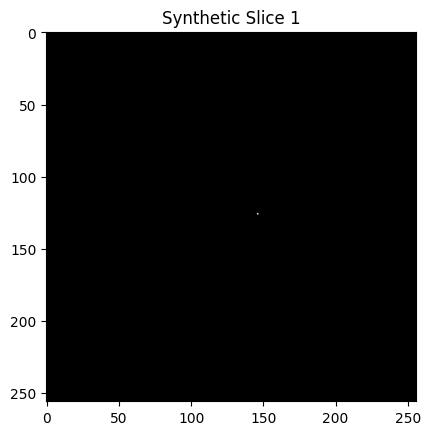

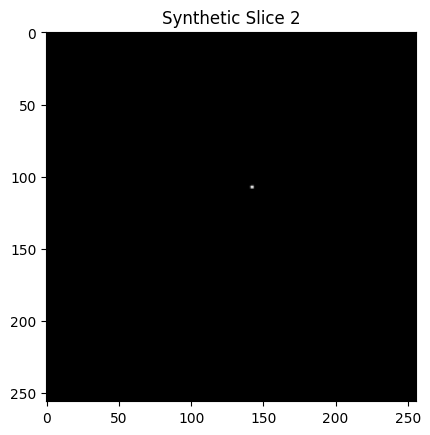

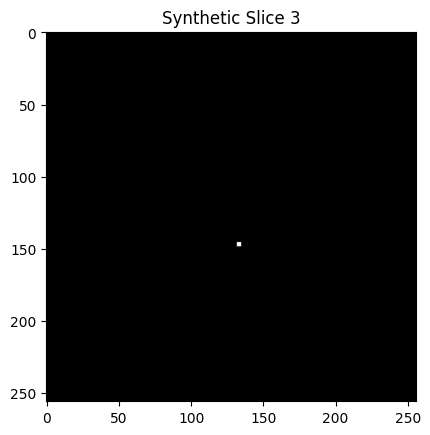

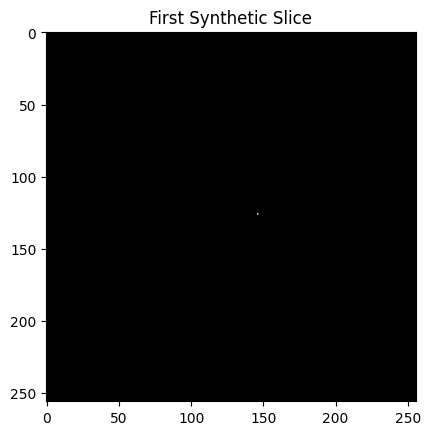

In [26]:
import numpy as np
import ants
import matplotlib.pyplot as plt
from skimage.draw import rectangle
from skimage.transform import rotate

def create_synthetic_slices(num_slices, shape=(256, 256), max_square_size=100, max_translation=20, max_rotation=15):
    """
    Generates synthetic slices with a growing square that undergoes random rotation and translation across slices.
    
    Parameters:
    num_slices (int): Number of slices to generate.
    shape (tuple): Shape of each slice (height, width).
    max_square_size (int): Maximum size of the square.
    max_translation (int): Maximum translation (in pixels) for each slice.
    max_rotation (int): Maximum rotation (in degrees) for each slice.
    
    Returns:
    List of ANTsImages containing the generated slices.
    """
    slices = []
    square_size_increment = max_square_size // num_slices  # Increase square size gradually

    for i in range(num_slices):
        # Create a blank image
        img_data = np.zeros(shape)
        
        
        # Calculate square size for the current slice
        square_size = min((i + 1) * square_size_increment, max_square_size)
        
        # Determine random translation (up to 20 pixels in each direction)
        translation_x = np.random.randint(-max_translation, max_translation)
        translation_y = np.random.randint(-max_translation, max_translation)
        
        # Draw the square at the center with the calculated size
        rr, cc = rectangle(start=(shape[0] // 2 - square_size // 2 + translation_y, 
                                  shape[1] // 2 - square_size // 2 + translation_x),
                           extent=(square_size, square_size), shape=shape)
        img_data[rr, cc] = np.random.rand()
        
        # Rotate the square randomly between 0 and 15 degrees
        rotated_square = rotate(img_data, np.random.uniform(0, max_rotation), resize=False, mode='reflect')
        
        # Convert to ANTsImage for registration
        ants_img = ants.from_numpy(rotated_square, origin=(0, 0), spacing=(1.0, 1.0), direction=np.eye(2))
        slices.append(ants_img)
        
        # Optionally, show the slices for visualization (only for the first 3 slices)
        if i < 3:
            plt.imshow(rotated_square, cmap='gray')
            plt.title(f"Synthetic Slice {i+1}")
            plt.show()

    return slices

# Test the function by generating 10 synthetic slices with growing squares
slices = create_synthetic_slices(100)

# Display the first generated slice
plt.imshow(slices[0].numpy(), cmap='gray')
plt.title("First Synthetic Slice")
plt.show()


In [27]:
# Save the synthetic slices to temporary files
pre_img_path = save_temp_image(slices[25])  # 4th slice as pre-image
post_img_path = save_temp_image(slices[27])  # 5th slice as post-image
current_img_path = save_temp_image(slices[26])  # 3rd slice as current-image for testing

# Test the intermediate slice generation
pre,post,intermediate_img = compute_intermediate_non_linear_slice(pre_img_path, post_img_path, current_img_path)


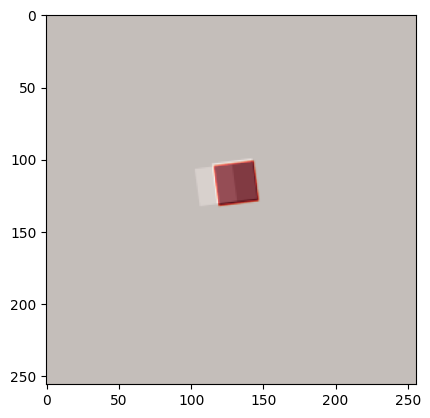

In [37]:
plt.imshow(slices[25].numpy(),cmap='grey',alpha=0.5)
plt.imshow(slices[27].numpy(),cmap='grey',alpha=0.5)
# plt.figure()
# plt.imshow(pre,cmap='Reds',alpha=0.7)
plt.imshow(post,cmap='Reds',alpha=0.7)
# plt.figure()


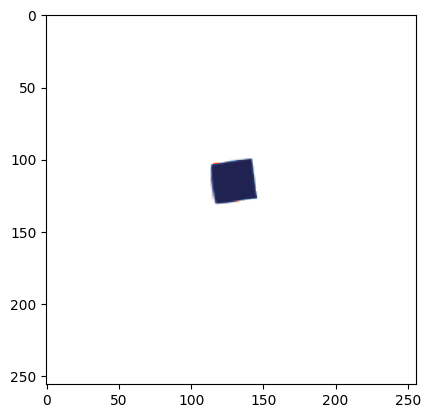

In [ ]:
# Load images using ANTs
pre_img = save_temp_image(slices[25])  # 4th slice as pre-image
post_img = save_temp_image(slices[27])  # 5th slice as post-image
pre_ants = ants.image_read(pre_img)
post_ants = ants.image_read(post_img)

avg_d = (pre_ants.numpy()+post_ants.numpy())/2 #this is a terrible average but we need to start somewhere
# Convert the data array to an ANTs image
new_image = ants.from_numpy(avg_d)
# Set the spatial information (origin, spacing, direction) from the reference image
new_image.set_origin(pre_ants.origin)
new_image.set_spacing(pre_ants.spacing)
new_image.set_direction(pre_ants.direction)

# Step 1: Perform rigid registration from pre to post slice and post to pre slice
pre_to_post_rigid = ants.registration(fixed=new_image, moving=pre_ants, type_of_transform='Rigid')
post_to_pre_rigid = ants.registration(fixed=new_image, moving=post_ants, type_of_transform='Rigid')
# pre_aligned = pre_to_post_rigid['warpedmovout']
# post_aligned = post_to_pre_rigid['warpedmovout']
# pre_aligned = ants.apply_transforms(fixed=post_ants, moving=pre_ants, transformlist=pre_to_post_rigid['fwdtransforms'])
# post_aligned = ants.apply_transforms(fixed=pre_ants, moving=post_ants, transformlist=post_to_pre_rigid['fwdtransforms'])

pre_to_post_nonlin = ants.registration(fixed=new_image, moving=pre_ants, type_of_transform='SyNOnly',
                                    initial_transform=pre_to_post_rigid['fwdtransforms'])
post_to_pre_nonlin = ants.registration(fixed=new_image, moving=post_ants, type_of_transform='SyNOnly',
                                    initial_transform=post_to_pre_rigid['fwdtransforms'])

# pre = pre_ants.numpy() #pre_to_post_nonlin['warpedfixout'].numpy()
# post = post_ants.numpy() #post_to_pre_nonlin['warpedfixout'].numpy()
pre = pre_to_post_nonlin['warpedmovout'].numpy()
post =post_to_pre_nonlin['warpedmovout'].numpy()
pre[pre==0]=np.nan
post[post==0]=np.nan
plt.imshow(pre,cmap='Reds')
plt.imshow(post,cmap='Blues',alpha=.75)


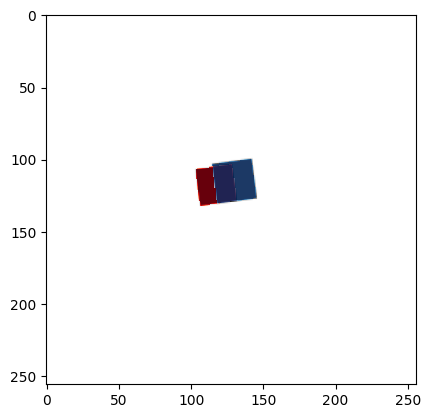

In [111]:
pre = pre_ants.numpy() #pre_to_post_nonlin['warpedfixout'].numpy()
post = post_ants.numpy() #post_to_pre_nonlin['warpedfixout'].numpy()
# pre = pre_to_post_nonlin['warpedmovout'].numpy()
# post =post_to_pre_nonlin['warpedmovout'].numpy()
pre[pre==0]=np.nan
post[post==0]=np.nan
plt.imshow(avg_d,cmap='Greys')
plt.imshow(pre,cmap='Reds')
plt.imshow(post,cmap='Blues',alpha=.75)


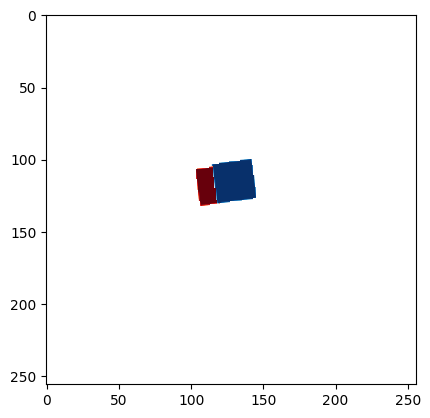

In [73]:
pre = pre_ants['warpedfixout'].numpy()
post = post_ants['warpedfixout'].numpy()
pre[pre==0]=np.nan
post[post==0]=np.nan
plt.imshow(pre,cmap='Reds')
plt.imshow(post,cmap='Blues')

In [59]:
import numpy as np
from scipy.spatial.transform import Rotation as R, Slerp

def compute_midpoint_transform(matrix1, matrix2):
    """
    Compute the midpoint transform between two affine transformation matrices.

    Parameters:
    - matrix1: np.ndarray
        The first 4x4 affine transformation matrix.
    - matrix2: np.ndarray
        The second 4x4 affine transformation matrix.

    Returns:
    - midpoint_matrix: np.ndarray
        The 4x4 affine transformation matrix representing the midpoint transform.
    """
    # Extract rotation and translation components
    rotation1 = matrix1[:3, :3]
    rotation2 = matrix2[:3, :3]
    translation1 = matrix1[:3, 3]
    translation2 = matrix2[:3, 3]

    # Convert rotation matrices to Rotation objects
    rot1 = R.from_matrix(rotation1)
    rot2 = R.from_matrix(rotation2)

    # SLERP interpolation for the midpoint rotation
    key_rots = R.concatenate([rot1, rot2])
    slerp = Slerp([0, 1], key_rots)
    midpoint_rotation = slerp(0.5).as_matrix()

    # Average translation vectors
    midpoint_translation = (translation1 + translation2) / 2

    # Construct the midpoint affine matrix
    midpoint_matrix = np.eye(4)
    midpoint_matrix[:3, :3] = midpoint_rotation
    midpoint_matrix[:3, 3] = midpoint_translation

    return midpoint_matrix


In [62]:
mat_file_path

['/tmp/tmpc7nwbivb0GenericAffine.mat']

In [69]:
# Path to the binary .mat file
mat_file_path = pre_to_post_rigid['fwdtransforms'][0]

# Load the transform using ANTsPy
transform = ants.read_transform(mat_file_path)

# Extract the affine parameters and fixed parameters
parameters = transform.parameters  # Contains the 6 affine parameters
fixed_parameters = transform.fixed_parameters  # Center of rotation (optional)

# Split the parameters
rotation_scaling = np.array(parameters[:4]).reshape(2, 2)  # 2x2 rotation-scaling matrix
translation = np.array(parameters[4:])  # 2D translation vector

# Adjust translation to account for the center of rotation (if provided)
# if fixed_parameters:
center = np.array(fixed_parameters)
adjusted_translation = translation + rotation_scaling @ center - center
# else:
#     adjusted_translation = translation

# Create the full 3x3 affine matrix for 2D
affine_matrix = np.eye(3)
affine_matrix[:2, :2] = rotation_scaling
affine_matrix[:2, 2] = adjusted_translation

# Display the result
print("Affine Transform Matrix (2D):")
print(affine_matrix)


Affine Transform Matrix (2D):
[[ 9.99954224e-01  9.56903212e-03  3.70981788e+00]
 [-9.56903212e-03  9.99954224e-01 -1.45408637e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [71]:
print(convert_2d_to_3d_affine(affine_matrix))

[[ 9.99954224e-01  9.56903212e-03  0.00000000e+00  3.70981788e+00]
 [-9.56903212e-03  9.99954224e-01  0.00000000e+00 -1.45408637e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [65]:
def convert_2d_to_3d_affine(affine_2d):
    """
    Converts a 2D affine matrix (3x3) into a 3D affine matrix (4x4)
    by assuming a singleton dimension for the third axis.
    
    Parameters:
        affine_2d (np.ndarray): 3x3 affine matrix for 2D.
    
    Returns:
        np.ndarray: 4x4 affine matrix for 3D.
    """
    # Initialize a 4x4 identity matrix
    affine_3d = np.eye(4)
    
    # Embed the 2D affine components into the 3D affine matrix
    affine_3d[:2, :2] = affine_2d[:2, :2]  # Rotation + scaling
    affine_3d[:2, 3] = affine_2d[:2, 2]    # Translation
    
    return affine_3d